In [2]:
# --- Required Libraries ---
import numpy as np                            # For numerical computations
import pandas as pd                          # For handling datasets
import random                                 # For generating random numbers

# --- For Visualizations (Data analysis) ---
import matplotlib.pyplot as plt               # For creating basic plots and graphs
import seaborn as sns                        # For enhanced visualizations (e.g., heatmaps, pairplots)
from matplotlib.lines import Line2D           # For advanced plotting (e.g., legends with custom lines)

# --- For Statistical Description (Descriptive statistics and statistical analysis) ---
import scipy.stats as stats                  # For statistical functions like skew, kurtosis
from sklearn.preprocessing import MinMaxScaler # For scaling and normalization

# --- For Preprocessing (Data cleaning, encoding, balancing, etc.) ---
from sklearn.model_selection import train_test_split # For splitting datasets into train, validation, and test sets
from sklearn.preprocessing import LabelEncoder           # For encoding categorical variables into numeric labels
from sklearn.impute import SimpleImputer                # For handling missing values (mean/median imputation)
from sklearn.utils import resample                      # For up/down sampling the dataset

# --- For LSTM (Deep Learning) (Model building and training) ---
import tensorflow as tf                             # TensorFlow for building and training deep learning models
from tensorflow.keras.models import Sequential      # For creating sequential models
from tensorflow.keras.models import Model           # For using the functional API to build models
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional # For LSTM layers and others
from tensorflow.keras.optimizers import Adam        # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping # Early stopping to prevent overfitting

# --- For Metrics (For evaluating model performance) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For regression evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix  # For classification metrics


2025-07-02 12:49:50.308372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the dataset
data = pd.read_csv('/Users/administrator/Desktop/All desktop-data/Dr.Ali/dataset/Dataset and Code/Dataset/iot_smart_city_dataset.csv')

# Display descriptive statistics
print("Descriptive Statistics for the Dataset:\n", data.describe())


Descriptive Statistics for the Dataset:
        uptime_hours  battery_capacity_mAh  energy_consumption_mAh  \
count  60000.000000          60000.000000            60000.000000   
mean      11.571667           3004.149850              186.828537   
std        6.920831           1153.084715              111.739189   
min        0.000000           1000.000000                0.000000   
25%        6.000000           2007.000000               96.872063   
50%       12.000000           3010.000000              193.744126   
75%       18.000000           3998.250000              290.616188   
max       23.000000           4999.000000              371.342907   

       temperature_C  humidity_percent  air_quality_index  motion_events  \
count   60000.000000      60000.000000       60000.000000   60000.000000   
mean       24.992034         82.505883         248.967000      49.442550   
std         5.768543          5.948904         144.015029      28.843315   
min        15.000169         70.0

In [4]:
# Check the columns in the dataset
print(data.columns)


Index(['timestamp', 'device_id', 'device_type', 'uptime_hours',
       'battery_capacity_mAh', 'energy_consumption_mAh', 'temperature_C',
       'humidity_percent', 'air_quality_index', 'motion_events',
       'light_intensity_lux', 'noise_level_dB', 'co2_emissions_ppm',
       'wind_speed_m_s', 'precipitation_mm_h', 'traffic_density_vehicles_h',
       'noise_pollution_level_dB', 'anomaly'],
      dtype='object')


In [5]:
# Rename columns for easier access
rename_dict = {
    'timestamp': 'TS', 'device_id': 'DID', 'device_type': 'Type', 
    'uptime_hours': 'UPU', 'battery_capacity_mAh': 'BC', 
    'energy_consumption_mAh': 'EC', 'temperature_C': 'Temp', 
    'humidity_percent': 'Hum', 'air_quality_index': 'AQI', 
    'motion_events': 'ME', 'light_intensity_lux': 'Lux', 
    'noise_level_dB': 'NL', 'co2_emissions_ppm': 'CO2', 
    'wind_speed_m_s': 'WS', 'precipitation_mm_h': 'Precip', 
    'traffic_density_vehicles_h': 'TDV', 'noise_pollution_level_dB': 'NPL', 
    'anomaly': 'Anom'
}
data.rename(columns=rename_dict, inplace=True)

# Features (input variables) and targets (outputs)
features = ['UPU', 'BC', 'Temp', 'Hum', 'AQI', 'ME', 'Lux', 'NL', 'CO2', 'WS', 'Precip', 'TDV', 'NPL']
X = data[features]  # Input features
y_energy = data['EC']  # Energy consumption target (regression)
y_anomaly = data['Anom']  # Anomaly detection target (binary classification)

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train_energy, y_val_energy, y_train_anomaly, y_val_anomaly = train_test_split(
    X, y_energy, y_anomaly, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")


Training set shape: (48000, 13), Validation set shape: (12000, 13)


In [6]:
# --- Scaling the features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [7]:
# --- Build the LSTM Model for EC (Energy Consumption) ---
model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# --- Compile the model ---
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score])

# Print model summary to check layers
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras import backend as K

# Define R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # R² formula


In [9]:
# --- Compile the model for Energy Consumption prediction ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # For regression
    metrics=[r2_metric]  # Use the custom R² metric
)


In [10]:
history = model.fit(
    X_train_reshaped, 
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_reshaped, y_val_energy),
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 38197.2578 - r2_metric: -2.2214 - val_loss: 22469.3340 - val_r2_metric: -0.9048
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20280.5996 - r2_metric: -0.6889 - val_loss: 14685.2949 - val_r2_metric: -0.2350
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 14235.4902 - r2_metric: -0.1835 - val_loss: 8433.3789 - val_r2_metric: 0.2914
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6780.7070 - r2_metric: 0.4364 - val_loss: 2815.6106 - val_r2_metric: 0.7650
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2648.4739 - r2_metric: 0.7824 - val_loss: 1134.4630 - val_r2_metric: 0.9058
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1357.8167 - r2_metric: 0.8877 - val_loss: 454.1658 - val_r2_metric: 0.9624
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 879.7164 - r2_metric: 0.9270 - val_loss: 210.9592 - val_r2_metric: 0.9825
Epoch 8/50
1500/1500 ━━━━━━

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 258.9872 - r2_metric: 0.9783 - val_loss: 7.3275 - val_r2_metric: 0.9994
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 253.9596 - r2_metric: 0.9788 - val_loss: 6.9463 - val_r2_metric: 0.9994


In [11]:
# --- Evaluate the model on validation data ---
y_pred_energy = model.predict(X_val_reshaped)

# Compute the evaluation metrics
mae = mean_absolute_error(y_val_energy, y_pred_energy)
mse = mean_squared_error(y_val_energy, y_pred_energy)
rmse = np.sqrt(mse)

# For R², TensorFlow's internal R² is used in the training process
train_r2 = history.history['r2_metric'][-1]  # Get the final R² for training
val_r2 = history.history['val_r2_metric'][-1]  # Get the final R² for validation

# Print final metrics for energy consumption (EC)
print(f"Final EC Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Training R²: {train_r2}")
print(f"Validation R²: {val_r2}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final EC Metrics:
MAE: 2.151058294266942
MSE: 6.946322933651081
RMSE: 2.6355877776410863
Training R²: 0.9784842133522034
Validation R²: 0.9994111061096191


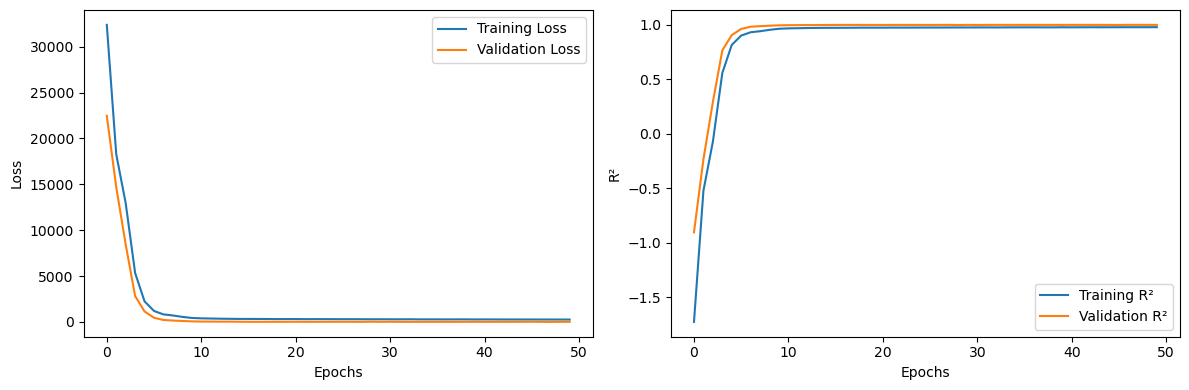

In [12]:
import matplotlib.pyplot as plt

# --- Create a figure with 1 row and 2 columns ---
plt.figure(figsize=(12, 4))

# --- First Plot: EC - Training and Validation Loss ---
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('EC - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- Second Plot: EC - R² Score Across Epochs ---
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
plt.plot(history.history['r2_metric'], label='Training R²')  # Training R²
plt.plot(history.history['val_r2_metric'], label='Validation R²')  # Validation R²
# plt.title('EC - R² Score Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# --- Adjust layout for better spacing ---
plt.tight_layout()

# --- Show the plots ---
plt.show()


In [13]:
# Store the final evaluation results in history
history_dict = history.history

# Print the final training and validation loss and R² metrics
print(f"Training Loss: {history_dict['loss'][-1]}")
print(f"Validation Loss: {history_dict['val_loss'][-1]}")
print(f"Training R²: {history_dict['r2_metric'][-1]}")
print(f"Validation R²: {history_dict['val_r2_metric'][-1]}")


Training Loss: 256.0382385253906
Validation Loss: 6.946324825286865
Training R²: 0.9784842133522034
Validation R²: 0.9994111061096191


In [52]:
# Step 1: Add 30% Noise to the Data
def add_noise_to_data(data, noise_level=0.3):  # 30% noise
    noisy_data = data.copy()
    numeric_features = features  # Using the features list for numeric columns

    for feature in numeric_features:
        noise = np.random.normal(loc=0, scale=noise_level * noisy_data[feature].mean(), size=len(noisy_data))
        noisy_data[feature] += noise
    
    return noisy_data

# Add 30% noise to the training and validation sets (no need for test data in this case)
X_train_noisy_30 = add_noise_to_data(X_train, noise_level=0.3)  # 30% noise
X_val_noisy_30 = add_noise_to_data(X_val, noise_level=0.3)      # 30% noise

# Verify that noise is added to the data (optional: print the first few rows)
print("Noisy data samples (30% noise):")
print(X_train_noisy_30.head())



Noisy data samples (30% noise):
             UPU           BC       Temp         Hum         AQI         ME  \
48572   8.003182  3137.981681  34.067246   92.762181  321.056175   9.884365   
38696  26.727210  2105.086696  14.790751  112.417726  361.103598  32.077160   
13611  -1.814755  3707.059508  29.517571  101.360052   40.564880  31.718258   
35213   6.691690  1768.062065  37.348960   77.216638  142.988829  86.843905   
31766   0.406913  2340.507257  39.634610   70.848238  399.733584  86.447677   

               Lux         NL         CO2         WS     Precip        TDV  \
48572  1151.242110  21.742783  332.533526   7.062327  14.943830 -27.646556   
38696   599.233224  30.080614  555.390624   6.342341  12.335664  13.017661   
13611  1605.903947  13.706553  362.082497  18.102284   0.014583  33.359180   
35213  1186.003033  -2.058544  261.570693  11.752914  11.808980  96.108984   
31766   639.190366  78.072605  505.094349   9.433635  14.905531  76.781109   

              NPL  
4857

In [54]:
# Step 2: Scale the noisy data (using the same scaler)
scaler = MinMaxScaler()

# Fit and transform the scaler on the noisy training data
X_train_noisy_30_scaled = scaler.fit_transform(X_train_noisy_30)
X_val_noisy_30_scaled = scaler.transform(X_val_noisy_30)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_noisy_30_reshaped = X_train_noisy_30_scaled.reshape((X_train_noisy_30_scaled.shape[0], 1, X_train_noisy_30_scaled.shape[1]))
X_val_noisy_30_reshaped = X_val_noisy_30_scaled.reshape((X_val_noisy_30_scaled.shape[0], 1, X_val_noisy_30_scaled.shape[1]))

# Optionally: Print the shape of reshaped data to verify
print(f"X_train_noisy_30_reshaped shape: {X_train_noisy_30_reshaped.shape}")
print(f"X_val_noisy_30_reshaped shape: {X_val_noisy_30_reshaped.shape}")


X_train_noisy_30_reshaped shape: (48000, 1, 13)
X_val_noisy_30_reshaped shape: (12000, 1, 13)


In [55]:
# Step 3: Build the LSTM Model for 30% Noisy Data
model = Sequential([
    LSTM(64, input_shape=(X_train_noisy_30_reshaped.shape[1], X_train_noisy_30_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])

# Print model summary
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Step 4: Train the model on 30% noisy data
history_30 = model.fit(
    X_train_noisy_30_reshaped,  # 30% noisy data
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_noisy_30_reshaped, y_val_energy),  # 30% noisy validation data
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 38982.7031 - r2_metric: -2.2616 - val_loss: 22524.7715 - val_r2_metric: -0.9095
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20355.8789 - r2_metric: -0.7023 - val_loss: 14709.1982 - val_r2_metric: -0.2370
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14368.1807 - r2_metric: -0.1949 - val_loss: 12601.2627 - val_r2_metric: -0.0551
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12920.4229 - r2_metric: -0.0640 - val_loss: 11114.3311 - val_r2_metric: 0.0690
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9864.6348 - r2_metric: 0.1819 - val_loss: 5463.1157 - val_r2_metric: 0.5408
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4995.1914 - r2_metric: 0.5823 - val_loss: 3412.9541 - val_r2_metric: 0.7106
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3532.9465 - r2_metric: 0.7044 - val_loss: 2856.3994 - val_r2_metric: 0.7561
Epoch 8/50
1500/150

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2610.9492 - r2_metric: 0.7772 - val_loss: 2320.6531 - val_r2_metric: 0.8005
Epoch 49/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2597.7891 - r2_metric: 0.7775 - val_loss: 2328.2371 - val_r2_metric: 0.7998
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2563.9255 - r2_metric: 0.7833 - val_loss: 2326.0828 - val_r2_metric: 0.7999


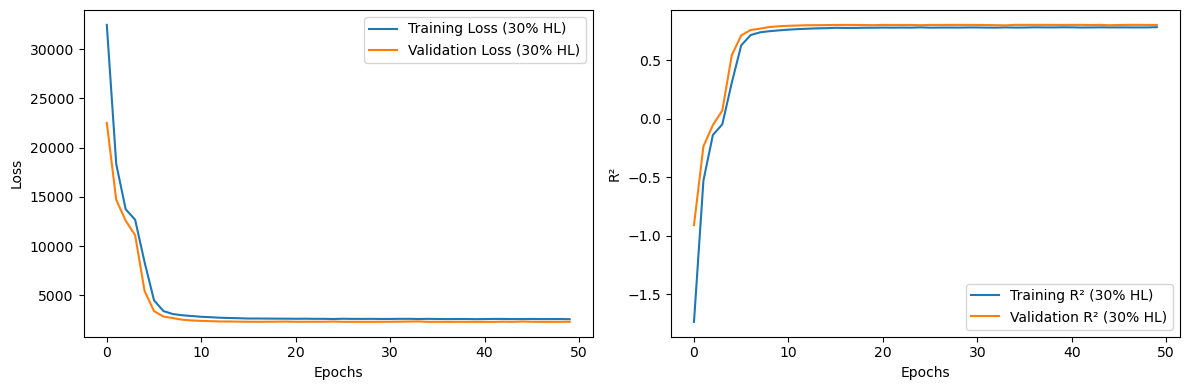

In [86]:
# Step 7: Plot the training and validation loss and R² metrics
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 4))

# First Plot: EC - Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_30.history['loss'], label='Training Loss (30% HL)')
plt.plot(history_30.history['val_loss'], label='Validation Loss (30% HL)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second Plot: EC - R² Score Across Epochs
plt.subplot(1, 2, 2)
plt.plot(history_30.history['r2_metric'], label='Training R² (30% HL)')
plt.plot(history_30.history['val_r2_metric'], label='Validation R² (30% HL)')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [57]:
# Step 5: Evaluate the model on validation data
y_pred_energy_30 = model.predict(X_val_noisy_30_reshaped)

# Compute the evaluation metrics
mae_30 = mean_absolute_error(y_val_energy, y_pred_energy_30)  # MAE on validation data
mse_30 = mean_squared_error(y_val_energy, y_pred_energy_30)   # MSE on validation data
rmse_30 = np.sqrt(mse_30)                                     # RMSE on validation data

# For R², TensorFlow's internal R² is used in the training process
train_r2_30 = history_30.history['r2_metric'][-1]  # Final R² for training on 30% noisy data
val_r2_30 = history_30.history['val_r2_metric'][-1]  # Final R² for validation on 30% noisy data

# Step 6: Print final metrics for energy consumption (EC) on 30% noisy data
print(f"Final EC Metrics for 30% Noisy Data:")
print(f"MAE: {mae_30}")
print(f"MSE: {mse_30}")
print(f"RMSE: {rmse_30}")
print(f"Training R²: {train_r2_30}")
print(f"Validation R²: {val_r2_30}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Final EC Metrics for 30% Noisy Data:
MAE: 38.03628049478659
MSE: 2326.0838274746366
RMSE: 48.229491262863604
Training R²: 0.7807773351669312
Validation R²: 0.799904465675354


In [60]:
# Step 1: Add 50% Noise to the Data
def add_noise_to_data(data, noise_level=0.5):  # 50% noise
    noisy_data = data.copy()
    numeric_features = features  # Using the features list for numeric columns

    for feature in numeric_features:
        noise = np.random.normal(loc=0, scale=noise_level * noisy_data[feature].mean(), size=len(noisy_data))
        noisy_data[feature] += noise
    
    return noisy_data

# Add 50% noise to the training and validation sets (no need for test data)
X_train_noisy_50 = add_noise_to_data(X_train, noise_level=0.5)  # 50% noise
X_val_noisy_50 = add_noise_to_data(X_val, noise_level=0.5)      # 50% noise

# Verify that noise is added to the data (optional: print the first few rows)
print("Noisy data samples (50% noise):")
print(X_train_noisy_50.head())



Noisy data samples (50% noise):
             UPU           BC       Temp         Hum         AQI         ME  \
48572  -0.653789  4295.344662  22.720962   46.244994  292.874182  20.662257   
38696  25.146441  1599.014258  -4.884714   -3.767123  229.784140   9.647512   
13611  -7.220468  3418.663342  33.452492   92.094260   85.298064  20.194530   
35213   6.260184  6126.926052  16.763575   27.015522  219.901556  63.838748   
31766  -4.393814  1892.602538  52.175147  105.172158  186.291875  64.635774   

               Lux         NL         CO2         WS     Precip        TDV  \
48572  1341.103087  52.122564  350.394909   4.207518  14.795672  11.755521   
38696  2046.275152  16.292523  600.307162  10.356482  11.272045  54.662333   
13611  1537.955232  38.964645  169.142064  26.709530  -2.690497  47.995951   
35213  1185.682619   4.606891  322.179116  17.407763  12.248773  73.090804   
31766   774.513886  14.582988  183.920857   9.281434  19.390348  69.771011   

              NPL  
4857

In [61]:
# Step 2: Scale the noisy data (using the same scaler)
scaler = MinMaxScaler()

# Fit and transform the scaler on the noisy training data
X_train_noisy_50_scaled = scaler.fit_transform(X_train_noisy_50)
X_val_noisy_50_scaled = scaler.transform(X_val_noisy_50)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_noisy_50_reshaped = X_train_noisy_50_scaled.reshape((X_train_noisy_50_scaled.shape[0], 1, X_train_noisy_50_scaled.shape[1]))
X_val_noisy_50_reshaped = X_val_noisy_50_scaled.reshape((X_val_noisy_50_scaled.shape[0], 1, X_val_noisy_50_scaled.shape[1]))

# Optionally: Print the shape of reshaped data to verify
print(f"X_train_noisy_50_reshaped shape: {X_train_noisy_50_reshaped.shape}")
print(f"X_val_noisy_50_reshaped shape: {X_val_noisy_50_reshaped.shape}")


X_train_noisy_50_reshaped shape: (48000, 1, 13)
X_val_noisy_50_reshaped shape: (12000, 1, 13)


In [62]:
# Step 3: Build the LSTM Model for 50% Noisy Data
model = Sequential([
    LSTM(64, input_shape=(X_train_noisy_50_reshaped.shape[1], X_train_noisy_50_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])

# Print model summary
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Step 4: Train the model on 50% noisy data
history_50 = model.fit(
    X_train_noisy_50_reshaped,  # 50% noisy data
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_noisy_50_reshaped, y_val_energy),  # 50% noisy validation data
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 38772.9375 - r2_metric: -2.2697 - val_loss: 22423.4434 - val_r2_metric: -0.9008
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20320.3281 - r2_metric: -0.6885 - val_loss: 14668.1436 - val_r2_metric: -0.2334
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14178.8691 - r2_metric: -0.1786 - val_loss: 12576.7676 - val_r2_metric: -0.0530
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12826.8711 - r2_metric: -0.0624 - val_loss: 12366.5449 - val_r2_metric: -0.0347
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 11915.5342 - r2_metric: 0.0171 - val_loss: 8443.4424 - val_r2_metric: 0.2920
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8093.9331 - r2_metric: 0.3286 - val_loss: 6190.0801 - val_r2_metric: 0.4784
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6316.0591 - r2_metric: 0.4726 - val_loss: 5591.1611 - val_r2_metric: 0.5268
Epoch 8/50
1500/1

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5273.9224 - r2_metric: 0.5587 - val_loss: 5020.6182 - val_r2_metric: 0.5732
Epoch 49/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5298.6045 - r2_metric: 0.5550 - val_loss: 5059.4146 - val_r2_metric: 0.5697
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5313.0859 - r2_metric: 0.5558 - val_loss: 5020.7358 - val_r2_metric: 0.5735


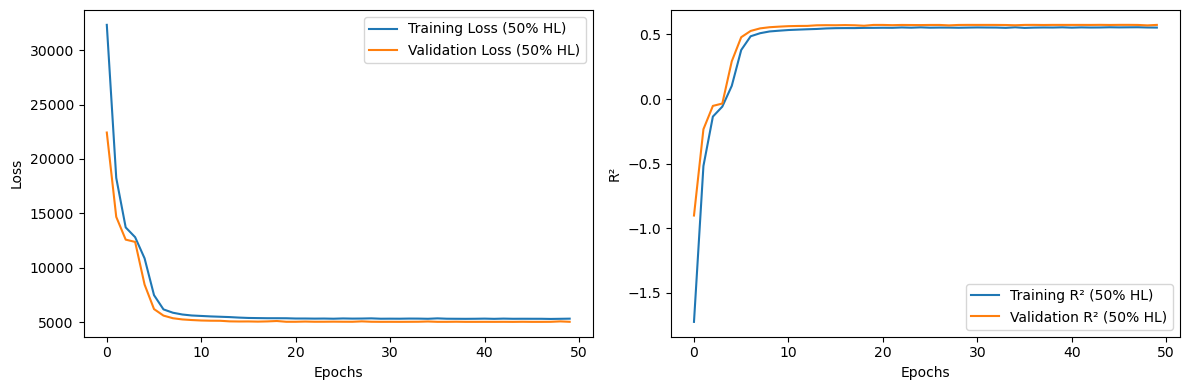

In [88]:
# Step 6: Plot the training and validation loss and R² metrics
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 4))

# First Plot: EC - Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_50.history['loss'], label='Training Loss (50% HL)')
plt.plot(history_50.history['val_loss'], label='Validation Loss (50% HL)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second Plot: EC - R² Score Across Epochs
plt.subplot(1, 2, 2)
plt.plot(history_50.history['r2_metric'], label='Training R² (50% HL)')
plt.plot(history_50.history['val_r2_metric'], label='Validation R² (50% HL)')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [65]:
# Step 5: Evaluate the model on validation data
y_pred_energy_50 = model.predict(X_val_noisy_50_reshaped)

# Compute the evaluation metrics
mae_50 = mean_absolute_error(y_val_energy, y_pred_energy_50)  # MAE on validation data
mse_50 = mean_squared_error(y_val_energy, y_pred_energy_50)   # MSE on validation data
rmse_50 = np.sqrt(mse_50)                                     # RMSE on validation data

# For R², TensorFlow's internal R² is used in the training process
train_r2_50 = history_50.history['r2_metric'][-1]  # Final R² for training on 50% noisy data
val_r2_50 = history_50.history['val_r2_metric'][-1]  # Final R² for validation on 50% noisy data

# Step 6: Print final metrics for energy consumption (EC) on 50% noisy data
print(f"Final EC Metrics for 50% Noisy Data:")
print(f"MAE: {mae_50}")
print(f"MSE: {mse_50}")
print(f"RMSE: {rmse_50}")
print(f"Training R²: {train_r2_50}")
print(f"Validation R²: {val_r2_50}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final EC Metrics for 50% Noisy Data:
MAE: 56.55889720533405
MSE: 5020.73808622701
RMSE: 70.85716679508863
Training R²: 0.5527009963989258
Validation R²: 0.5734682083129883


In [66]:
# Step 1: Add 100% Noise to the Data
def add_noise_to_data(data, noise_level=1.0):  # 100% noise
    noisy_data = data.copy()
    numeric_features = features  # Using the features list for numeric columns

    for feature in numeric_features:
        noise = np.random.normal(loc=0, scale=noise_level * noisy_data[feature].mean(), size=len(noisy_data))
        noisy_data[feature] += noise
    
    return noisy_data

# Add 100% noise to the training and validation sets (no need for test data)
X_train_noisy_100 = add_noise_to_data(X_train, noise_level=1.0)  # 100% noise
X_val_noisy_100 = add_noise_to_data(X_val, noise_level=1.0)      # 100% noise

# Verify that noise is added to the data (optional: print the first few rows)
print("Noisy data samples (100% noise):")
print(X_train_noisy_100.head())


Noisy data samples (100% noise):
             UPU           BC       Temp         Hum         AQI          ME  \
48572   8.636979  1227.165951  23.955101   39.481048  595.167753   -1.427640   
38696   2.088832  3978.155747  12.217074  199.953338  870.333337   32.872419   
13611  -0.814065  6658.818754  41.624919  169.055913   44.112960  -21.362361   
35213  13.495815  4495.121994   6.105607   33.987678  123.733951   90.424665   
31766  -9.785023  3219.847012  34.670247   46.378224  317.758728  138.492800   

               Lux         NL         CO2         WS     Precip         TDV  \
48572   413.644254 -13.479627  554.950599  13.893001  13.332025  -77.048332   
38696  2289.442130  36.677985  830.206656  29.175884  15.206830  -52.176975   
13611  2207.275042 -70.128829  628.097135  16.703373  -7.003589  -37.049089   
35213  2911.199375  68.732900  480.767238   5.461703   2.020514  244.760828   
31766  3285.171190  21.860185  702.698243  31.922173  11.450349   38.462235   

           

In [67]:
# Step 2: Scale the noisy data (using the same scaler)
scaler = MinMaxScaler()

# Fit and transform the scaler on the noisy training data
X_train_noisy_100_scaled = scaler.fit_transform(X_train_noisy_100)
X_val_noisy_100_scaled = scaler.transform(X_val_noisy_100)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_noisy_100_reshaped = X_train_noisy_100_scaled.reshape((X_train_noisy_100_scaled.shape[0], 1, X_train_noisy_100_scaled.shape[1]))
X_val_noisy_100_reshaped = X_val_noisy_100_scaled.reshape((X_val_noisy_100_scaled.shape[0], 1, X_val_noisy_100_scaled.shape[1]))

# Optionally: Print the shape of reshaped data to verify
print(f"X_train_noisy_100_reshaped shape: {X_train_noisy_100_reshaped.shape}")
print(f"X_val_noisy_100_reshaped shape: {X_val_noisy_100_reshaped.shape}")


X_train_noisy_100_reshaped shape: (48000, 1, 13)
X_val_noisy_100_reshaped shape: (12000, 1, 13)


In [68]:
# Step 3: Build the LSTM Model for 100% Noisy Data
model = Sequential([
    LSTM(64, input_shape=(X_train_noisy_100_reshaped.shape[1], X_train_noisy_100_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])

# Print model summary
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Step 4: Train the model on 100% noisy data
history_100 = model.fit(
    X_train_noisy_100_reshaped,  # 100% noisy data
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_noisy_100_reshaped, y_val_energy),  # 100% noisy validation data
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 38985.5859 - r2_metric: -2.2876 - val_loss: 22360.0156 - val_r2_metric: -0.8954
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20135.9629 - r2_metric: -0.6877 - val_loss: 14643.3623 - val_r2_metric: -0.2313
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14199.0801 - r2_metric: -0.1798 - val_loss: 12578.7236 - val_r2_metric: -0.0532
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 12796.5859 - r2_metric: -0.0593 - val_loss: 12371.5684 - val_r2_metric: -0.0351
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12709.2578 - r2_metric: -0.0499 - val_loss: 11890.7070 - val_r2_metric: 0.0041
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 11745.8574 - r2_metric: 0.0248 - val_loss: 10260.8223 - val_r2_metric: 0.1393
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 10409.5195 - r2_metric: 0.1335 - val_loss: 9585.7031 - val_r2_metric: 0.1932
Epoch 8/50
1

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9593.9150 - r2_metric: 0.2023 - val_loss: 9161.9346 - val_r2_metric: 0.2261
Epoch 49/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9507.1680 - r2_metric: 0.2070 - val_loss: 9185.6943 - val_r2_metric: 0.2237
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9532.4766 - r2_metric: 0.2053 - val_loss: 9175.4844 - val_r2_metric: 0.2247


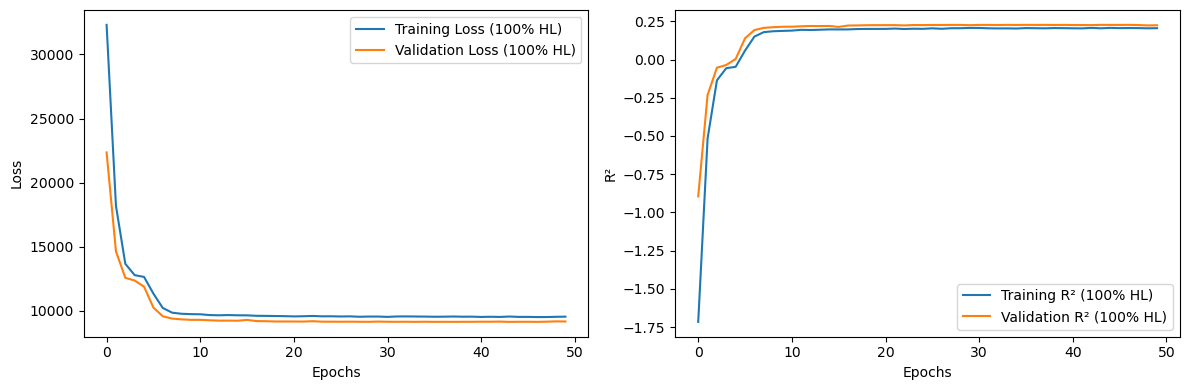

In [90]:
# Step 6: Plot the training and validation loss and R² metrics
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 4))

# First Plot: EC - Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_100.history['loss'], label='Training Loss (100% HL)')
plt.plot(history_100.history['val_loss'], label='Validation Loss (100% HL)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second Plot: EC - R² Score Across Epochs
plt.subplot(1, 2, 2)
plt.plot(history_100.history['r2_metric'], label='Training R² (100% HL)')
plt.plot(history_100.history['val_r2_metric'], label='Validation R² (100% HL)')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [74]:
# Step 5: Evaluate the model on validation data
y_pred_energy_100 = model.predict(X_val_noisy_100_reshaped)

# Compute the evaluation metrics
mae_100 = mean_absolute_error(y_val_energy, y_pred_energy_100)  # MAE on validation data
mse_100 = mean_squared_error(y_val_energy, y_pred_energy_100)   # MSE on validation data
rmse_100 = np.sqrt(mse_100)                                     # RMSE on validation data

# For R², TensorFlow's internal R² is used in the training process
train_r2_100 = history_100.history['r2_metric'][-1]  # Final R² for training on 100% noisy data
val_r2_100 = history_100.history['val_r2_metric'][-1]  # Final R² for validation on 100% noisy data

# Step 6: Print final metrics for energy consumption (EC) on 100% noisy data
print(f"Final EC Metrics for 100% Noisy Data:")
print(f"MAE: {mae_100}")
print(f"MSE: {mse_100}")
print(f"RMSE: {rmse_100}")
print(f"Training R²: {train_r2_100}")
print(f"Validation R²: {val_r2_100}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Final EC Metrics for 100% Noisy Data:
MAE: 79.91422905910198
MSE: 9175.481129101627
RMSE: 95.78873174388325
Training R²: 0.2055404633283615
Validation R²: 0.22468966245651245


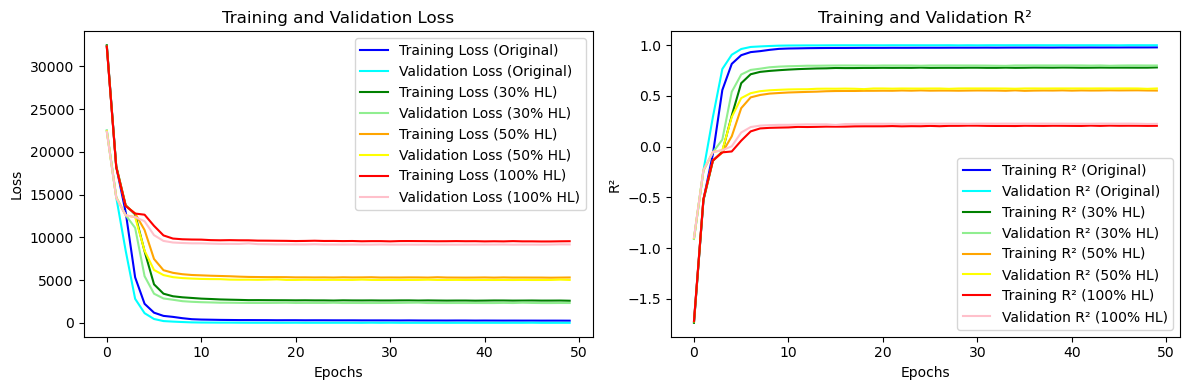

In [107]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 4))

# First Plot: Combined Loss (Training and Validation Loss for Original, 30%, 50%, and 100% HL)
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
# Plot the training and validation loss for Original, 30%, 50%, and 100% HL
plt.plot(history.history['loss'], label='Training Loss (Original)', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss (Original)', color='cyan')

plt.plot(history_30.history['loss'], label='Training Loss (30% HL)', color='green')
plt.plot(history_30.history['val_loss'], label='Validation Loss (30% HL)', color='lightgreen')

plt.plot(history_50.history['loss'], label='Training Loss (50% HL)', color='orange')
plt.plot(history_50.history['val_loss'], label='Validation Loss (50% HL)', color='yellow')

plt.plot(history_100.history['loss'], label='Training Loss (100% HL)', color='red')
plt.plot(history_100.history['val_loss'], label='Validation Loss (100% HL)', color='pink')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Second Plot: Combined R² Scores (Training and Validation R² for Original, 30%, 50%, and 100% HL)
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
# Plot the training and validation R² for Original, 30%, 50%, and 100% HL
plt.plot(history.history['r2_metric'], label='Training R² (Original)', color='blue')
plt.plot(history.history['val_r2_metric'], label='Validation R² (Original)', color='cyan')

plt.plot(history_30.history['r2_metric'], label='Training R² (30% HL)', color='green')
plt.plot(history_30.history['val_r2_metric'], label='Validation R² (30% HL)', color='lightgreen')

plt.plot(history_50.history['r2_metric'], label='Training R² (50% HL)', color='orange')
plt.plot(history_50.history['val_r2_metric'], label='Validation R² (50% HL)', color='yellow')

plt.plot(history_100.history['r2_metric'], label='Training R² (100% HL)', color='red')
plt.plot(history_100.history['val_r2_metric'], label='Validation R² (100% HL)', color='pink')

plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.title('Training and Validation R²')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


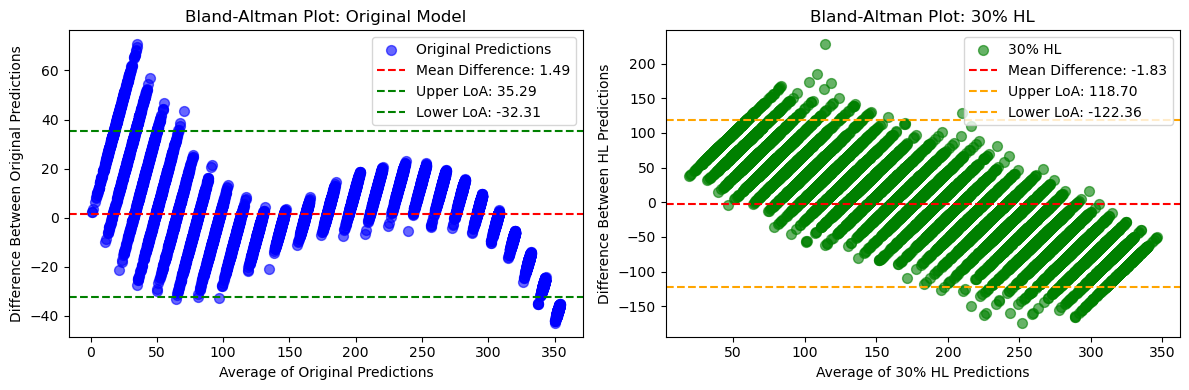

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predictions from the original and 30% noisy models
y_pred_original = model.predict(X_val_reshaped)  # Predictions for original data
y_pred_noisy_30 = model.predict(X_val_noisy_30_reshaped)  # Predictions for 30% noisy data

# Step 2: Calculate the differences between the predictions and the true values (y_val_energy)
differences_original = y_pred_original.flatten() - y_val_energy.flatten()  # Differences for original data
differences_noisy_30 = y_pred_noisy_30.flatten() - y_val_energy.flatten()  # Differences for 30% noisy data

# Step 3: Calculate the averages of the predictions and true values
averages_original = (y_pred_original.flatten() + y_val_energy.flatten()) / 2
averages_noisy_30 = (y_pred_noisy_30.flatten() + y_val_energy.flatten()) / 2

# Step 4: Calculate the mean and standard deviation of the differences for both models
mean_diff_original = np.mean(differences_original)
std_diff_original = np.std(differences_original)

mean_diff_noisy_30 = np.mean(differences_noisy_30)
std_diff_noisy_30 = np.std(differences_noisy_30)

# Step 5: Calculate the upper and lower limits of agreement (LoA) for both models
upper_LoA_original = mean_diff_original + 1.96 * std_diff_original
lower_LoA_original = mean_diff_original - 1.96 * std_diff_original

upper_LoA_noisy_30 = mean_diff_noisy_30 + 1.96 * std_diff_noisy_30
lower_LoA_noisy_30 = mean_diff_noisy_30 - 1.96 * std_diff_noisy_30

# Step 6: Create the combined plot
plt.figure(figsize=(12, 4))

# First Plot: Bland-Altman for Original Data Model
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
plt.scatter(averages_original, differences_original, color='blue', alpha=0.6, label='Original Predictions', s=50)
plt.axhline(mean_diff_original, color='red', linestyle='--', label=f'Mean Difference: {mean_diff_original:.2f}')
plt.axhline(upper_LoA_original, color='green', linestyle='--', label=f'Upper LoA: {upper_LoA_original:.2f}')
plt.axhline(lower_LoA_original, color='green', linestyle='--', label=f'Lower LoA: {lower_LoA_original:.2f}')
plt.xlabel('Average of Original Predictions')
plt.ylabel('Difference Between Original Predictions')
plt.title('Bland-Altman Plot: Original Model')
plt.legend()

# Second Plot: Bland-Altman for 30% Noisy Data Model
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
plt.scatter(averages_noisy_30, differences_noisy_30, color='green', alpha=0.6, label='30% HL', s=50)
plt.axhline(mean_diff_noisy_30, color='red', linestyle='--', label=f'Mean Difference: {mean_diff_noisy_30:.2f}')
plt.axhline(upper_LoA_noisy_30, color='orange', linestyle='--', label=f'Upper LoA: {upper_LoA_noisy_30:.2f}')
plt.axhline(lower_LoA_noisy_30, color='orange', linestyle='--', label=f'Lower LoA: {lower_LoA_noisy_30:.2f}')
plt.xlabel('Average of 30% HL Predictions')
plt.ylabel('Difference Between HL Predictions')
plt.title('Bland-Altman Plot: 30% HL')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


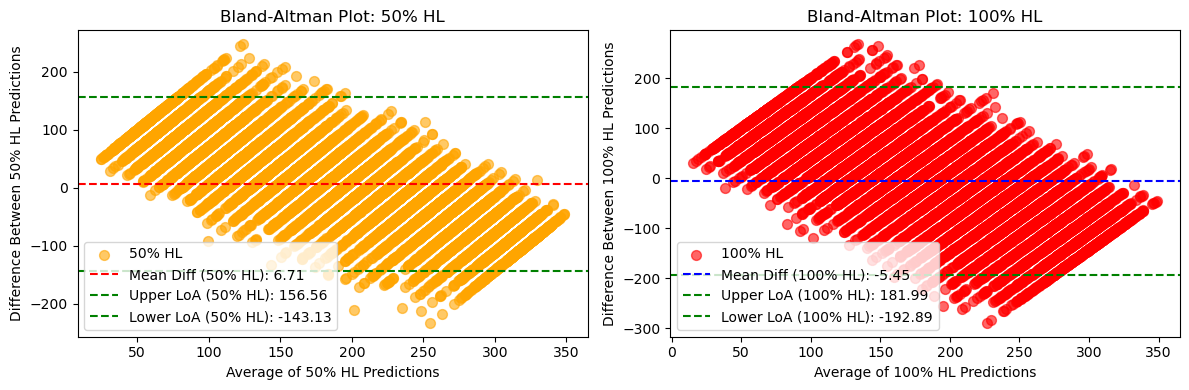

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predictions from the original and noisy models
y_pred_original = model.predict(X_val_reshaped)  # Predictions for original data
y_pred_noisy_30 = model.predict(X_val_noisy_30_reshaped)  # Predictions for 30% noisy data
y_pred_noisy_50 = model.predict(X_val_noisy_50_reshaped)  # Predictions for 50% noisy data
y_pred_noisy_100 = model.predict(X_val_noisy_100_reshaped)  # Predictions for 100% noisy data

# Step 2: Calculate the differences between the predictions and the true values (y_val_energy)
differences_noisy_50 = y_pred_noisy_50.flatten() - y_val_energy.flatten()  # Differences for 50% noisy data
differences_noisy_100 = y_pred_noisy_100.flatten() - y_val_energy.flatten()  # Differences for 100% noisy data

# Step 3: Calculate the averages of the predictions and true values
averages_noisy_50 = (y_pred_noisy_50.flatten() + y_val_energy.flatten()) / 2
averages_noisy_100 = (y_pred_noisy_100.flatten() + y_val_energy.flatten()) / 2

# Step 4: Calculate the mean and standard deviation of the differences for both models
mean_diff_noisy_50 = np.mean(differences_noisy_50)
std_diff_noisy_50 = np.std(differences_noisy_50)

mean_diff_noisy_100 = np.mean(differences_noisy_100)
std_diff_noisy_100 = np.std(differences_noisy_100)

# Step 5: Calculate the upper and lower limits of agreement (LoA) for both models
upper_LoA_noisy_50 = mean_diff_noisy_50 + 1.96 * std_diff_noisy_50
lower_LoA_noisy_50 = mean_diff_noisy_50 - 1.96 * std_diff_noisy_50

upper_LoA_noisy_100 = mean_diff_noisy_100 + 1.96 * std_diff_noisy_100
lower_LoA_noisy_100 = mean_diff_noisy_100 - 1.96 * std_diff_noisy_100

# Step 6: Create the side-by-side Bland-Altman plot
plt.figure(figsize=(12, 4))

# First Plot: Bland-Altman for 50% Noisy Data Model
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
plt.scatter(averages_noisy_50, differences_noisy_50, color='orange', alpha=0.6, label='50% HL', s=50)
plt.axhline(mean_diff_noisy_50, color='red', linestyle='--', label=f'Mean Diff (50% HL): {mean_diff_noisy_50:.2f}')
plt.axhline(upper_LoA_noisy_50, color='green', linestyle='--', label=f'Upper LoA (50% HL): {upper_LoA_noisy_50:.2f}')
plt.axhline(lower_LoA_noisy_50, color='green', linestyle='--', label=f'Lower LoA (50% HL): {lower_LoA_noisy_50:.2f}')
plt.xlabel('Average of 50% HL Predictions')
plt.ylabel('Difference Between 50% HL Predictions')
plt.title('Bland-Altman Plot: 50% HL')
plt.legend()

# Second Plot: Bland-Altman for 100% Noisy Data Model
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
plt.scatter(averages_noisy_100, differences_noisy_100, color='red', alpha=0.6, label='100% HL', s=50)
plt.axhline(mean_diff_noisy_100, color='blue', linestyle='--', label=f'Mean Diff (100% HL): {mean_diff_noisy_100:.2f}')
plt.axhline(upper_LoA_noisy_100, color='green', linestyle='--', label=f'Upper LoA (100% HL): {upper_LoA_noisy_100:.2f}')
plt.axhline(lower_LoA_noisy_100, color='green', linestyle='--', label=f'Lower LoA (100% HL): {lower_LoA_noisy_100:.2f}')
plt.xlabel('Average of 100% HL Predictions')
plt.ylabel('Difference Between 100% HL Predictions')
plt.title('Bland-Altman Plot: 100% HL')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


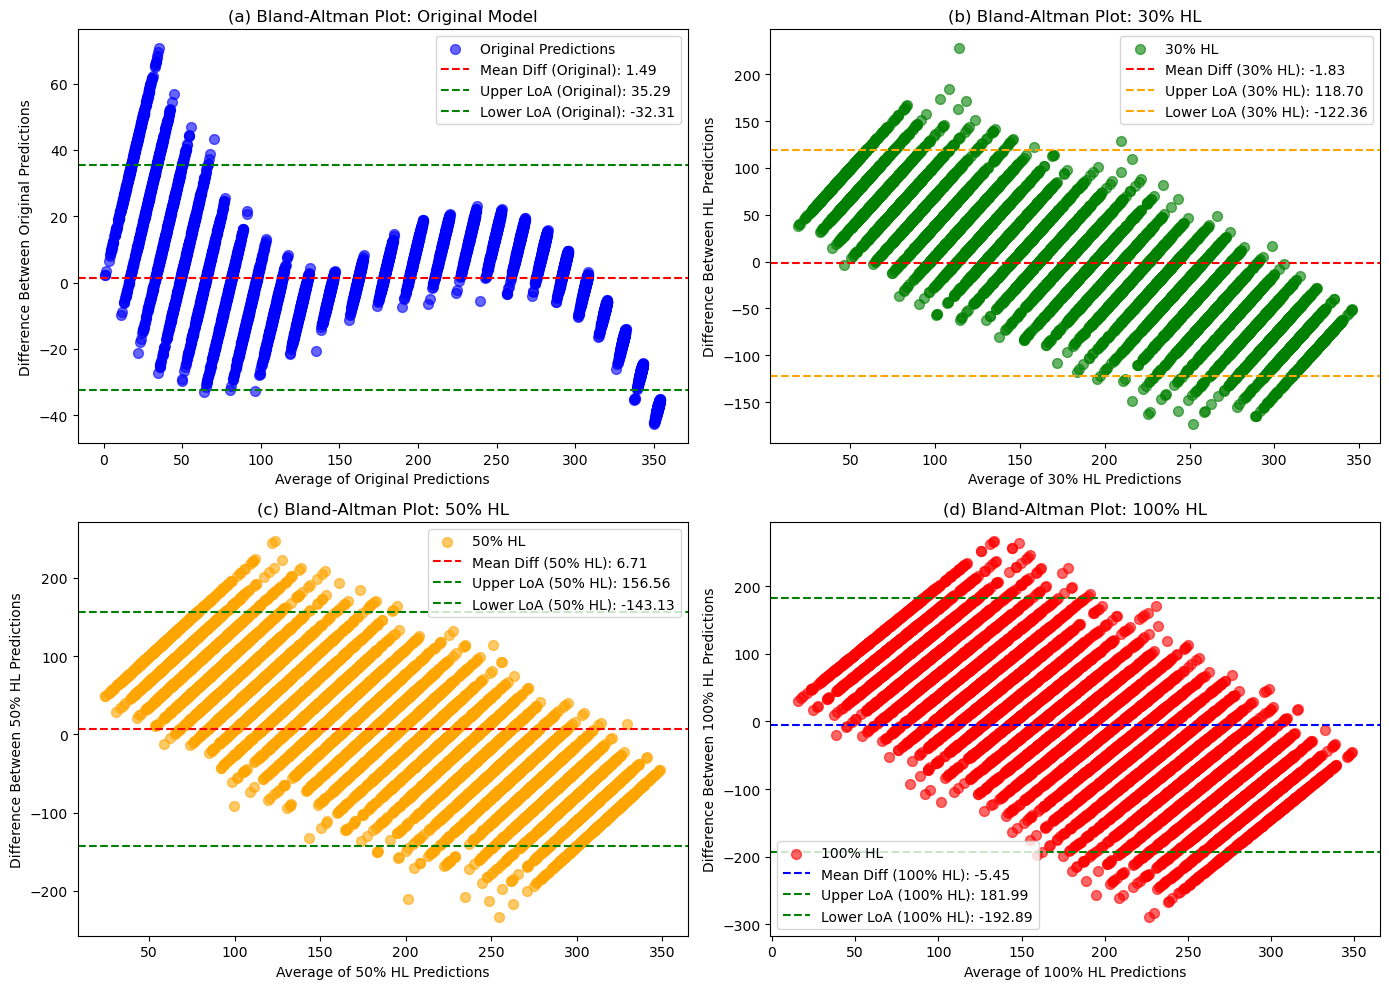

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the original and noisy models
y_pred_original = model.predict(X_val_reshaped)  # Predictions for original data
y_pred_noisy_30 = model.predict(X_val_noisy_30_reshaped)  # Predictions for 30% noisy data
y_pred_noisy_50 = model.predict(X_val_noisy_50_reshaped)  # Predictions for 50% noisy data
y_pred_noisy_100 = model.predict(X_val_noisy_100_reshaped)  # Predictions for 100% noisy data

# Calculate the differences between the predictions and the true values (y_val_energy)
differences_original = y_pred_original.flatten() - y_val_energy.flatten()  # Differences for original data
differences_noisy_30 = y_pred_noisy_30.flatten() - y_val_energy.flatten()  # Differences for 30% noisy data
differences_noisy_50 = y_pred_noisy_50.flatten() - y_val_energy.flatten()  # Differences for 50% noisy data
differences_noisy_100 = y_pred_noisy_100.flatten() - y_val_energy.flatten()  # Differences for 100% noisy data

# Calculate the averages of the predictions and true values
averages_original = (y_pred_original.flatten() + y_val_energy.flatten()) / 2
averages_noisy_30 = (y_pred_noisy_30.flatten() + y_val_energy.flatten()) / 2
averages_noisy_50 = (y_pred_noisy_50.flatten() + y_val_energy.flatten()) / 2
averages_noisy_100 = (y_pred_noisy_100.flatten() + y_val_energy.flatten()) / 2

# Calculate the mean and standard deviation of the differences for both models
mean_diff_original = np.mean(differences_original)
std_diff_original = np.std(differences_original)

mean_diff_noisy_30 = np.mean(differences_noisy_30)
std_diff_noisy_30 = np.std(differences_noisy_30)

mean_diff_noisy_50 = np.mean(differences_noisy_50)
std_diff_noisy_50 = np.std(differences_noisy_50)

mean_diff_noisy_100 = np.mean(differences_noisy_100)
std_diff_noisy_100 = np.std(differences_noisy_100)

# Calculate the upper and lower limits of agreement (LoA) for both models
upper_LoA_original = mean_diff_original + 1.96 * std_diff_original
lower_LoA_original = mean_diff_original - 1.96 * std_diff_original

upper_LoA_noisy_30 = mean_diff_noisy_30 + 1.96 * std_diff_noisy_30
lower_LoA_noisy_30 = mean_diff_noisy_30 - 1.96 * std_diff_noisy_30

upper_LoA_noisy_50 = mean_diff_noisy_50 + 1.96 * std_diff_noisy_50
lower_LoA_noisy_50 = mean_diff_noisy_50 - 1.96 * std_diff_noisy_50

upper_LoA_noisy_100 = mean_diff_noisy_100 + 1.96 * std_diff_noisy_100
lower_LoA_noisy_100 = mean_diff_noisy_100 - 1.96 * std_diff_noisy_100

# Create the side-by-side Bland-Altman plot (4 plots)
plt.figure(figsize=(14, 10))

# First Plot: Bland-Altman for Original Data Model
plt.subplot(2, 2, 1)  # First subplot (2 rows, 2 columns, first plot)
plt.scatter(averages_original, differences_original, color='blue', alpha=0.6, label='Original Predictions', s=50)
plt.axhline(mean_diff_original, color='red', linestyle='--', label=f'Mean Diff (Original): {mean_diff_original:.2f}')
plt.axhline(upper_LoA_original, color='green', linestyle='--', label=f'Upper LoA (Original): {upper_LoA_original:.2f}')
plt.axhline(lower_LoA_original, color='green', linestyle='--', label=f'Lower LoA (Original): {lower_LoA_original:.2f}')
plt.xlabel('Average of Original Predictions')
plt.ylabel('Difference Between Original Predictions')
plt.title('(a) Bland-Altman Plot: Original Model')
plt.legend()

# Second Plot: Bland-Altman for 30% Noisy Data Model
plt.subplot(2, 2, 2)  # Second subplot (2 rows, 2 columns, second plot)
plt.scatter(averages_noisy_30, differences_noisy_30, color='green', alpha=0.6, label='30% HL', s=50)
plt.axhline(mean_diff_noisy_30, color='red', linestyle='--', label=f'Mean Diff (30% HL): {mean_diff_noisy_30:.2f}')
plt.axhline(upper_LoA_noisy_30, color='orange', linestyle='--', label=f'Upper LoA (30% HL): {upper_LoA_noisy_30:.2f}')
plt.axhline(lower_LoA_noisy_30, color='orange', linestyle='--', label=f'Lower LoA (30% HL): {lower_LoA_noisy_30:.2f}')
plt.xlabel('Average of 30% HL Predictions')
plt.ylabel('Difference Between HL Predictions')
plt.title('(b) Bland-Altman Plot: 30% HL')
plt.legend()

# Third Plot: Bland-Altman for 50% Noisy Data Model
plt.subplot(2, 2, 3)  # Third subplot (2 rows, 2 columns, third plot)
plt.scatter(averages_noisy_50, differences_noisy_50, color='orange', alpha=0.6, label='50% HL', s=50)
plt.axhline(mean_diff_noisy_50, color='red', linestyle='--', label=f'Mean Diff (50% HL): {mean_diff_noisy_50:.2f}')
plt.axhline(upper_LoA_noisy_50, color='green', linestyle='--', label=f'Upper LoA (50% HL): {upper_LoA_noisy_50:.2f}')
plt.axhline(lower_LoA_noisy_50, color='green', linestyle='--', label=f'Lower LoA (50% HL): {lower_LoA_noisy_50:.2f}')
plt.xlabel('Average of 50% HL Predictions')
plt.ylabel('Difference Between 50% HL Predictions')
plt.title('(c) Bland-Altman Plot: 50% HL')
plt.legend()

# Fourth Plot: Bland-Altman for 100% Noisy Data Model
plt.subplot(2, 2, 4)  # Fourth subplot (2 rows, 2 columns, fourth plot)
plt.scatter(averages_noisy_100, differences_noisy_100, color='red', alpha=0.6, label='100% HL', s=50)
plt.axhline(mean_diff_noisy_100, color='blue', linestyle='--', label=f'Mean Diff (100% HL): {mean_diff_noisy_100:.2f}')
plt.axhline(upper_LoA_noisy_100, color='green', linestyle='--', label=f'Upper LoA (100% HL): {upper_LoA_noisy_100:.2f}')
plt.axhline(lower_LoA_noisy_100, color='green', linestyle='--', label=f'Lower LoA (100% HL): {lower_LoA_noisy_100:.2f}')
plt.xlabel('Average of 100% HL Predictions')
plt.ylabel('Difference Between 100% HL Predictions')
plt.title('(d) Bland-Altman Plot: 100% HL')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
